<a href="https://colab.research.google.com/github/ParisaEb/The-Elderly-carehub_IOT-Project/blob/main/Noise_Handelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
!pip install pm4py
import pm4py
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Define activity list with dependencies and variations for a loan process
activities = {
    "Apply for Loan": ["Check Credit Score", "Collect Documents"],
    "Check Credit Score": ["Loan Officer Review"],
    "Collect Documents": ["Loan Officer Review"],
    "Loan Officer Review": ["Approve Loan", "Request Additional Documents", "Reject Loan"],
    "Request Additional Documents": ["Collect Additional Documents"],
    "Collect Additional Documents": ["Loan Officer Review"],
    "Approve Loan": ["Disburse Loan", "Notify Applicant"],
    "Disburse Loan": ["Start Loan Repayment"],
    "Start Loan Repayment": ["Monitor Repayment"],
    "Monitor Repayment": ["Close Loan", "Flag for Delinquency"],
    "Flag for Delinquency": ["Initiate Collection Process"],
    "Initiate Collection Process": ["Collect Debt", "Write Off Debt"],
    "Collect Debt": ["Close Loan"],
    "Write Off Debt": [],
    "Reject Loan": ["Notify Applicant"],
    "Notify Applicant": [],
    "Close Loan": []
}

# Define logical durations for each activity
logical_durations = {
    "Apply for Loan": timedelta(hours=random.uniform(1, 3)),
    "Check Credit Score": timedelta(minutes=random.uniform(30, 60)),
    "Collect Documents": timedelta(days=random.uniform(2, 7)),
    "Loan Officer Review": timedelta(days=random.uniform(1, 3)),
    "Request Additional Documents": timedelta(days=random.uniform(1, 2)),
    "Collect Additional Documents": timedelta(days=random.uniform(2, 5)),
    "Approve Loan": timedelta(hours=random.uniform(1, 2)),
    "Disburse Loan": timedelta(days=random.uniform(1, 3)),
    "Start Loan Repayment": timedelta(days=random.uniform(1, 7)),
    "Monitor Repayment": timedelta(days=random.uniform(30, 365)),  # Monitoring could last for a long time
    "Flag for Delinquency": timedelta(days=random.uniform(10, 30)),
    "Initiate Collection Process": timedelta(days=random.uniform(5, 15)),
    "Collect Debt": timedelta(days=random.uniform(30, 90)),
    "Write Off Debt": timedelta(days=random.uniform(10, 20)),
    "Reject Loan": timedelta(hours=random.uniform(1, 2)),
    "Notify Applicant": timedelta(hours=random.uniform(1, 2)),
    "Close Loan": timedelta(hours=random.uniform(1, 2))
}

# Function to inject noise into the process
def inject_noise(logs):
    noise_type = random.choice(['add', 'remove', 'reorder', 'duplicate'])

    if noise_type == 'add':
        # Add a random activity at a random position
        random_activity = random.choice(list(activities.keys()))
        random_position = random.randint(0, len(logs) - 1)
        logs.insert(random_position, (logs[0][0], random_activity, logs[random_position][2]))

    elif noise_type == 'remove' and len(logs) > 1:
        # Remove a random activity
        random_position = random.randint(0, len(logs) - 1)
        logs.pop(random_position)

    elif noise_type == 'reorder' and len(logs) > 1:
        # Swap two random activities
        pos1, pos2 = random.sample(range(len(logs)), 2)
        logs[pos1], logs[pos2] = logs[pos2], logs[pos1]

    elif noise_type == 'duplicate':
        # Duplicate a random activity
        random_position = random.randint(0, len(logs) - 1)
        logs.insert(random_position, logs[random_position])

    return logs

# Function to generate logs for a single loan case
def generate_logs(case_id, noise_probability=0.1):
    logs = []
    current_activity = "Apply for Loan"
    timestamp = datetime.now()
    while current_activity:
        logs.append((case_id, current_activity, timestamp))
        next_activities = activities[current_activity]
        if next_activities:
            current_activity = random.choice(next_activities)
            # Add logical duration to timestamp
            timestamp += logical_durations.get(current_activity, timedelta(seconds=0))
        else:
            break  # No subsequent activities defined, end the loop

    # Inject noise based on the specified probability
    if random.random() < noise_probability:
        logs = inject_noise(logs)

    return logs

# Generate logs for multiple loan cases
def generate_dataset(num_cases, noise_probability=0.1):
    dataset = []
    for case_id in range(1, num_cases + 1):
        logs = generate_logs(case_id, noise_probability)
        dataset.extend(logs)
    return dataset

# Generate dataset
num_cases = 5000  # Lower the number for quicker testing
noise_probability = 0.2  # Increase this to inject more noise
dataset = generate_dataset(num_cases, noise_probability)

# Create DataFrame from dataset
df = pd.DataFrame(dataset, columns=['Case ID', 'Activity', 'Timestamp'])

# Add resources and location columns
df['Resources'] = ''
df['Location'] = ''

# Populate resources and location columns based on activity
for case_id, group in df.groupby('Case ID'):
    df.loc[df['Case ID'] == case_id, 'Resources'] = random.choice(['Loan Officer A', 'Loan Officer B', 'Loan Officer C'])  # Random loan officer
    # Add random location of the bank branch or online platform
    df.loc[df['Case ID'] == case_id, 'Location'] = random.choice(['New York', 'London', 'Dubai', 'Paris', 'Tokyo', 'Singapore'])

# Save logs to CSV file
df.to_csv('loan_application_logs_with_noise.csv', index=False)


In [27]:
import pandas as pd

# Load event log
event_log = pd.read_csv('loan_application_logs_with_noise.csv')

# Preview the loaded event log
print(event_log.head())


   Case ID             Activity                   Timestamp       Resources  \
0        1       Apply for Loan  2024-09-25 10:38:51.803654  Loan Officer C   
1        1   Check Credit Score  2024-09-25 11:12:35.595717  Loan Officer C   
2        1  Loan Officer Review  2024-09-28 05:47:04.084433  Loan Officer C   
3        1         Approve Loan  2024-09-28 07:24:20.165970  Loan Officer C   
4        1        Disburse Loan  2024-09-30 14:21:11.595275  Loan Officer C   

    Location  
0  Singapore  
1  Singapore  
2  Singapore  
3  Singapore  
4  Singapore  


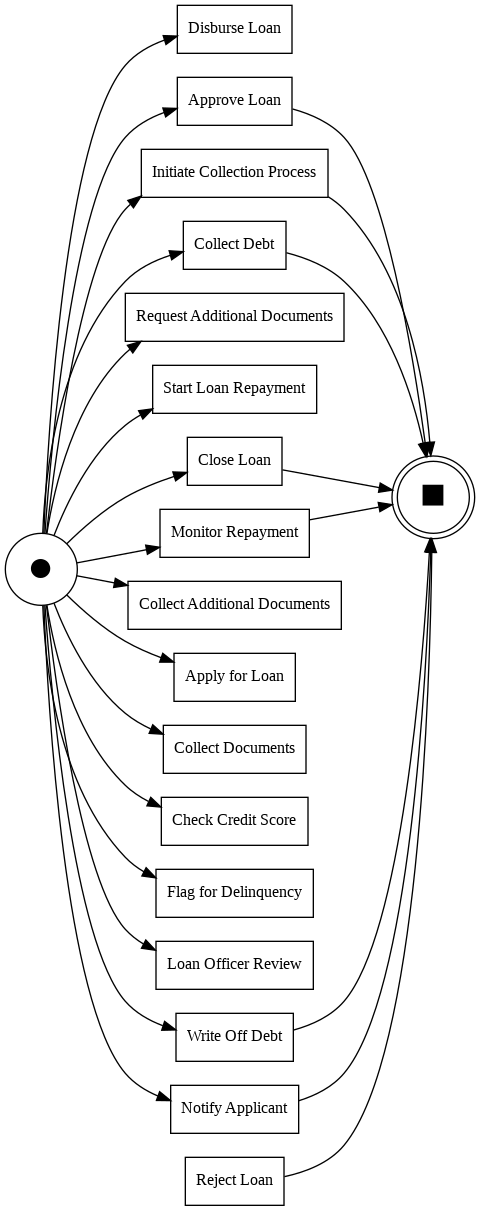

In [28]:
import pm4py
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.filtering.log.variants import variants_filter

import pm4py

# Convert to PM4PY log format
event_log['time:timestamp'] = pd.to_datetime(event_log['Timestamp'])  # Convert timestamp to datetime format

# Convert DataFrame to EventLog object
log = pm4py.format_dataframe(event_log, case_id='Case ID', activity_key='Activity', timestamp_key='time:timestamp')

from pm4py.algo.discovery.alpha import algorithm as inductive_miner

# Discover process model from log using the Inductive Miner
net, initial_marking, final_marking = inductive_miner.apply(log)

# Visualize the process model
pm4py.visualization.petri_net.visualizer.apply(net, initial_marking, final_marking)
pm4py.view_petri_net(net, initial_marking, final_marking)




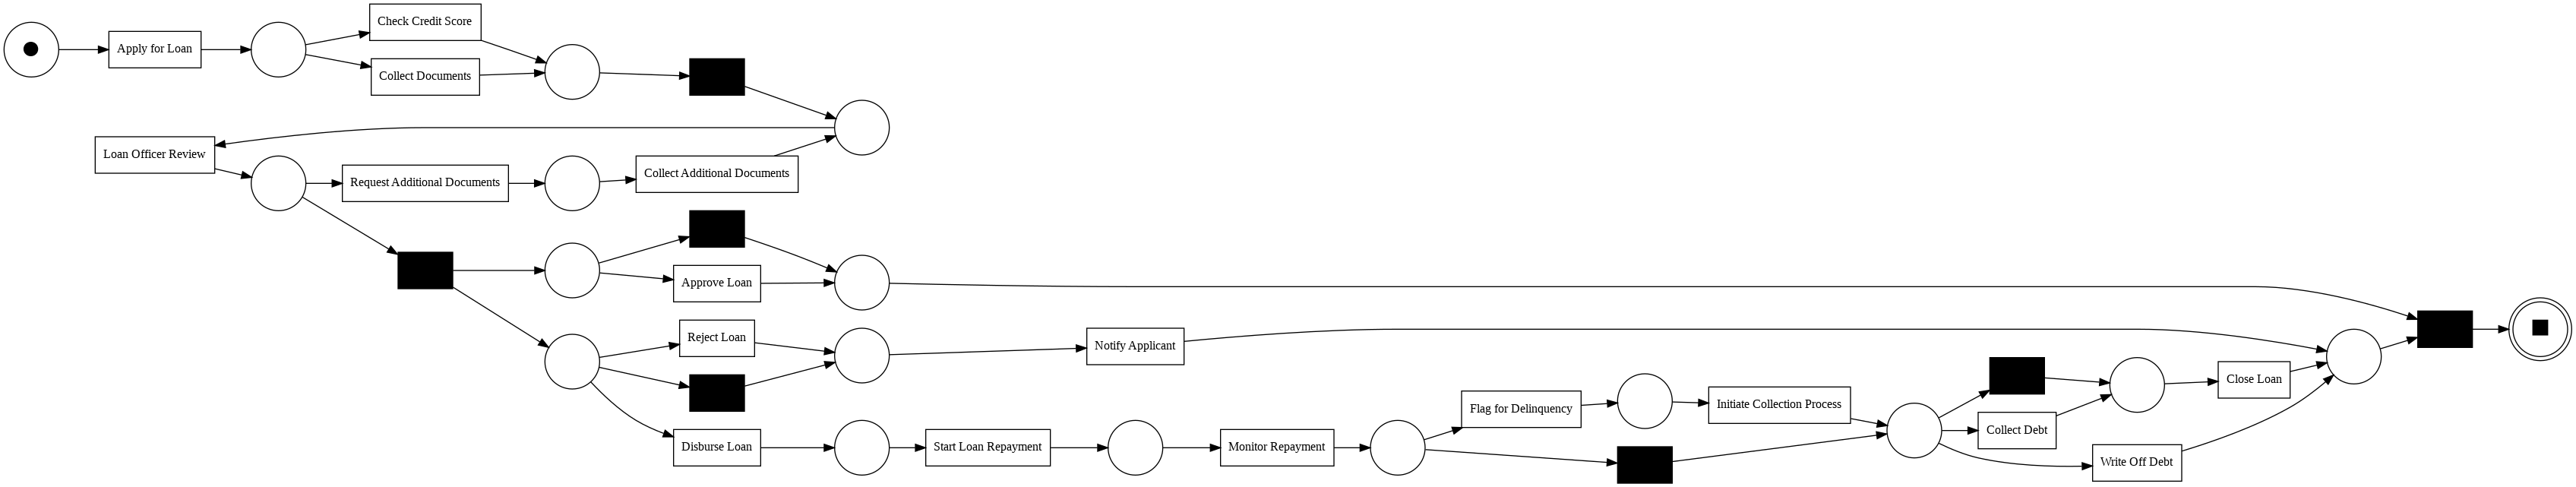

In [29]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Filter variants that appear frequently in the log (e.g., retain variants that appear more than 1% of the time)
filtered_log = variants_filter.filter_variants_by_coverage_percentage(log, 0.01)

# Apply the Inductive Miner to get a ProcessTree
process_tree = inductive_miner.apply(filtered_log, variant=inductive_miner.Variants.IMf)

# Convert the ProcessTree to a Petri net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

# Visualize the discovered Petri net
pm4py.view_petri_net(net, initial_marking, final_marking)

In [30]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

replay_result = token_replay.apply(log, net, initial_marking, final_marking)

# Print conformance results
for trace_index, result in enumerate(replay_result):
    print(f"Trace {trace_index}: {result}")

# Summarize the conformance results (optional)
total_traces = len(replay_result)
fit_traces = sum(1 for result in replay_result if result['trace_is_fit'])
print(f"Total Traces: {total_traces}")
print(f"Fit Traces: {fit_traces}")
print(f"Fitness Percentage: {fit_traces / total_traces * 100:.2f}%")

replaying log with TBR, completed traces ::   0%|          | 0/435 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Trace 3: {'trace_is_fit': False, 'trace_fitness': 0.9444444444444444, 'activated_transitions': [(24d629e7-c573-4cbb-807c-f76445249f71, 'Apply for Loan'), (35964396-841a-49a8-b3fc-aaeee06b44e4, 'Check Credit Score'), (init_loop_1, None), (402e3603-2926-4314-b57a-24eb4ab751d4, 'Loan Officer Review'), (9f5d19eb-fdce-440c-bf12-bba7e0a205ca, 'Request Additional Documents'), (b8d36f4e-9092-40c8-8f05-471e368ef41c, 'Collect Additional Documents'), (402e3603-2926-4314-b57a-24eb4ab751d4, 'Loan Officer Review'), (9f5d19eb-fdce-440c-bf12-bba7e0a205ca, 'Request Additional Documents'), (b8d36f4e-9092-40c8-8f05-471e368ef41c, 'Collect Additional Documents'), (402e3603-2926-4314-b57a-24eb4ab751d4, 'Loan Officer Review'), (skip_3, None), (4f2ac500-7547-4e23-95f4-125555d5f113, 'Reject Loan'), (b8d36f4e-9092-40c8-8f05-471e368ef41c, 'Collect Additional Documents'), (365d4d07-3a4f-45a2-b81f-b483c8c4787b, 'Notify Applicant'), (skip_6, None), (tauJoin_5, None

In [31]:
non_conforming_traces = [result for result in replay_result if not result['trace_is_fit']]
print(f"Non-conforming traces count: {len(non_conforming_traces)}")
for idx, trace_result in enumerate(non_conforming_traces):
    print(f"Non-conforming Trace {idx}: {trace_result}")


Non-conforming traces count: 710
Non-conforming Trace 0: {'trace_is_fit': False, 'trace_fitness': 0.9444444444444444, 'activated_transitions': [(24d629e7-c573-4cbb-807c-f76445249f71, 'Apply for Loan'), (35964396-841a-49a8-b3fc-aaeee06b44e4, 'Check Credit Score'), (init_loop_1, None), (402e3603-2926-4314-b57a-24eb4ab751d4, 'Loan Officer Review'), (9f5d19eb-fdce-440c-bf12-bba7e0a205ca, 'Request Additional Documents'), (b8d36f4e-9092-40c8-8f05-471e368ef41c, 'Collect Additional Documents'), (402e3603-2926-4314-b57a-24eb4ab751d4, 'Loan Officer Review'), (9f5d19eb-fdce-440c-bf12-bba7e0a205ca, 'Request Additional Documents'), (b8d36f4e-9092-40c8-8f05-471e368ef41c, 'Collect Additional Documents'), (402e3603-2926-4314-b57a-24eb4ab751d4, 'Loan Officer Review'), (skip_3, None), (4f2ac500-7547-4e23-95f4-125555d5f113, 'Reject Loan'), (b8d36f4e-9092-40c8-8f05-471e368ef41c, 'Collect Additional Documents'), (365d4d07-3a4f-45a2-b81f-b483c8c4787b, 'Notify Applicant'), (skip_6, None), (tauJoin_5, None)],

In [32]:
!pip install --upgrade pm4py

from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
alignment_results = alignments.apply(log, net, initial_marking, final_marking)
print(alignment_results)

aligning log, completed variants ::   0%|          | 0/435 [00:00<?, ?it/s]

[{'alignment': [('Apply for Loan', 'Apply for Loan'), ('Check Credit Score', 'Check Credit Score'), ('>>', None), ('Loan Officer Review', 'Loan Officer Review'), ('>>', None), ('Approve Loan', 'Approve Loan'), ('Disburse Loan', 'Disburse Loan'), ('Start Loan Repayment', 'Start Loan Repayment'), ('Monitor Repayment', 'Monitor Repayment'), ('Flag for Delinquency', 'Flag for Delinquency'), ('Initiate Collection Process', 'Initiate Collection Process'), ('Collect Debt', 'Collect Debt'), ('Close Loan', 'Close Loan'), ('>>', None)], 'cost': 3, 'visited_states': 14, 'queued_states': 49, 'traversed_arcs': 49, 'lp_solved': 3, 'fitness': 1.0, 'bwc': 150005}, {'alignment': [('Apply for Loan', 'Apply for Loan'), ('Collect Documents', 'Collect Documents'), ('>>', None), ('Loan Officer Review', 'Loan Officer Review'), ('>>', None), ('Approve Loan', 'Approve Loan'), ('Disburse Loan', 'Disburse Loan'), ('Start Loan Repayment', 'Start Loan Repayment'), ('Monitor Repayment', 'Monitor Repayment'), ('Flag

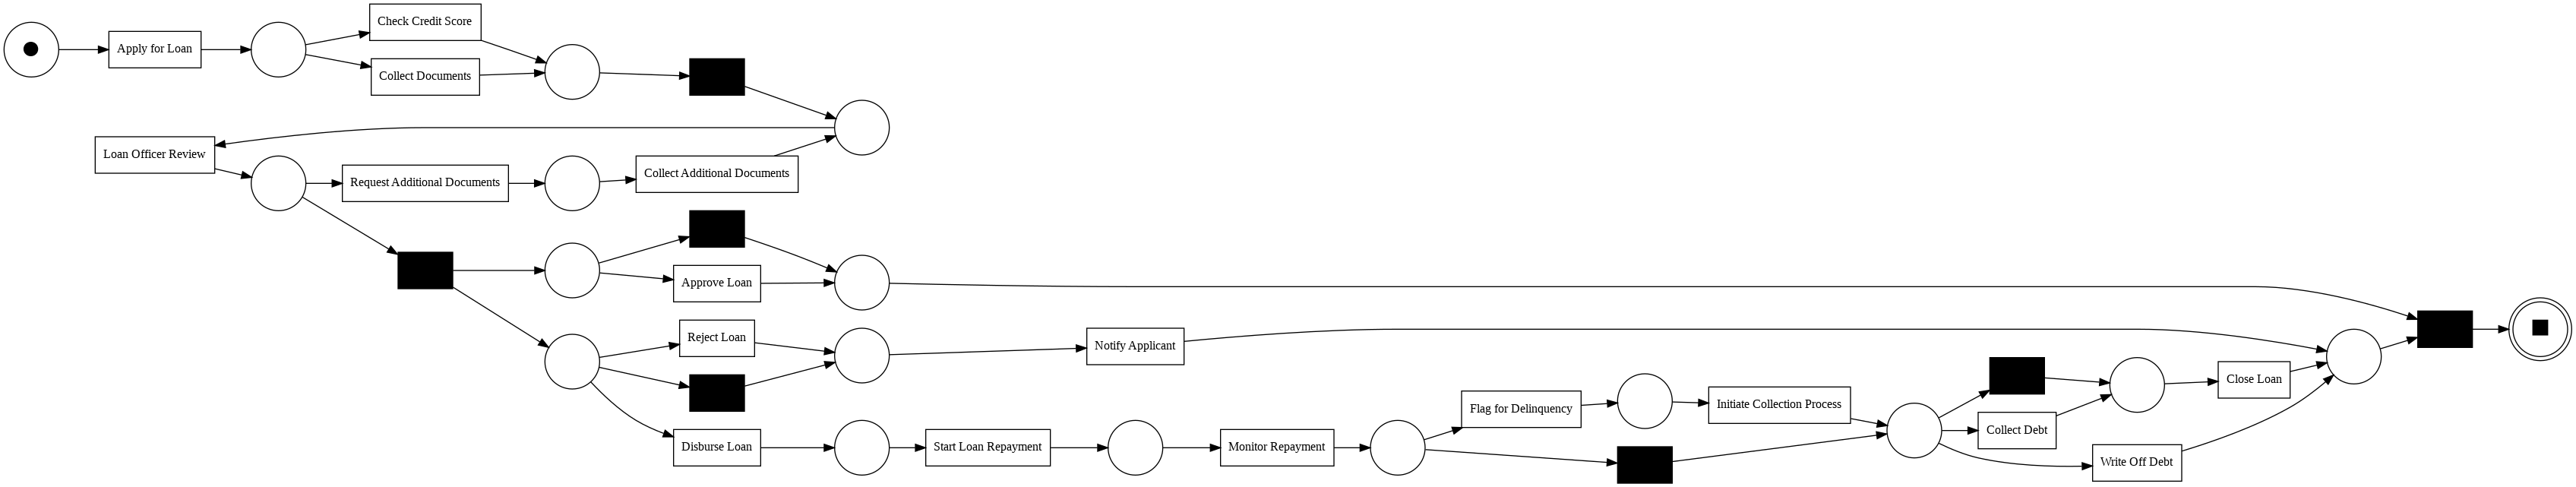

In [33]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters={"format": "png"})
pn_visualizer.view(gviz)


In [34]:
# Define counters for the summary
perfect_matches = 0
missing_in_log = 0
extra_in_log = 0

# Loop through the alignment results
for result in alignment_results:
    for step in result['alignment']:
        if step[0] == step[1]:
            # Perfect match: both the log and the model have the same activity
            perfect_matches += 1
        elif step[0] is None:
            # Missing in log: the model expects an activity that is not present in the log
            missing_in_log += 1
        elif step[1] is None:
            # Extra in log: the log has an activity that is not in the model
            extra_in_log += 1

# Output summary statistics
total_steps = perfect_matches + missing_in_log + extra_in_log
print(f"Total steps: {total_steps}")
print(f"Perfect matches: {perfect_matches}")
print(f"Missing in log: {missing_in_log}")
print(f"Extra in log: {extra_in_log}")


Total steps: 57074
Perfect matches: 36991
Missing in log: 0
Extra in log: 20083


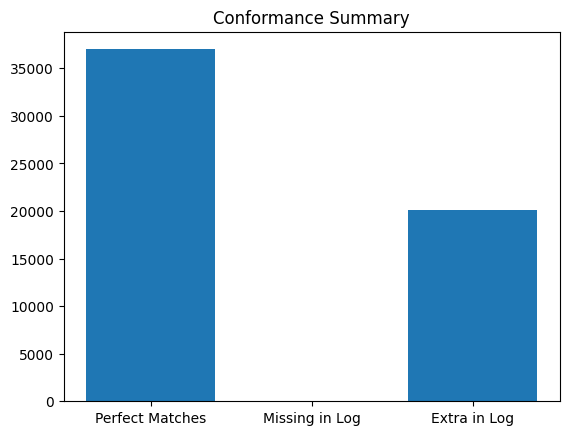

In [35]:
import matplotlib.pyplot as plt

labels = ['Perfect Matches', 'Missing in Log', 'Extra in Log']
values = [perfect_matches, missing_in_log, extra_in_log]

plt.bar(labels, values)
plt.title('Conformance Summary')
plt.show()
